In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.nn.functional as F
from sophia import SophiaG
from sklearn.datasets import make_classification
import pandas as pd
import matplotlib.pyplot as plt
from model import MLP



   feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0  -0.408485  -0.122709   0.093372  -0.661987   0.389124  -0.966618   
1  -2.605207   0.216625  -1.025753  -0.720825  -2.558713  -0.218043   
2  -0.379465   0.000207  -0.009300  -1.025990   0.953223  -1.596094   
3  -0.350429  -0.657373  -0.048965   0.798114  -1.632769   1.490972   
4  -0.775486   0.190917  -0.036331   0.516457  -1.814064   1.176754   

   feature_7  feature_8  feature_9  feature_10  target  
0  -0.960046  -0.595556   0.476797   -1.654887       0  
1  -0.937926  -1.338861   3.049574    0.338553       0  
2   1.121031  -0.841983   0.441903   -0.822420       0  
3   0.566772   0.448666   0.412424   -0.114802       1  
4  -1.684668   0.114983   0.909574   -0.075871       1  


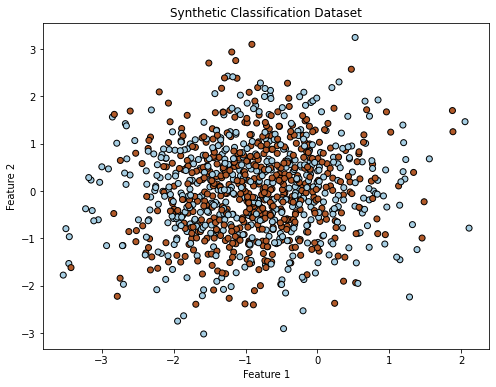

In [2]:
# Set the seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# Generate a synthetic classification dataset
X, y = make_classification(
    n_samples=1000,  # Adjust the number of samples as needed
    n_features=10,
    n_classes=2,
    n_clusters_per_class=1,
    n_redundant=4,
    random_state=seed
)

input_features = 10
output_classes = 2

# Create a Pandas DataFrame for better visualization and manipulation
columns = [f"feature_{i}" for i in range(1, 11)]
df = pd.DataFrame(X, columns=columns)
df['target'] = y

# Visualize the first few rows of the dataset
print(df.head())

# Plot a scatter plot of the dataset (only for 2D visualization)
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 9], c=y, cmap=plt.cm.Paired, marker='o', edgecolors='k')
plt.title('Synthetic Classification Dataset')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [3]:
class Classification_Model(nn.Module):
    def __init__(self, input, output):
        super().__init__()
        self.layer1 = nn.Linear(input, 5) 
        self.layer2 = nn.Linear(5, output) 
    def forward(self, x): 
        return self.layer2(self.layer1(x))

In [4]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    
# Create a CustomDataset instance
dataset = CustomDataset(X, y)


# Create a DataLoader
batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


for batch_X, batch_y in dataloader:
    # Your training logic goes here
    print("Batch X shape:", batch_X.shape)
    print("Batch y shape:", batch_y.shape)
    break  # Break to show just the first batch

Batch X shape: torch.Size([64, 10])
Batch y shape: torch.Size([64])


In [9]:


# init model loss function and input data
model = MLP(input=input_features, output=output_classes, bias=False)
data_loader = dataloader
#optimizer = optim.SGD(model.parameters(), lr=0.001)
learning_rate = 2e-4
loss_fn = torch.nn.CrossEntropyLoss()
# init the optimizer
optimizer = SophiaG(model.parameters(), lr=2e-4, betas=(0.965, 0.99), rho=0.01, weight_decay=1e-1)
rho = 0.01
total_bs = len(data_loader)
bs = batch_size
k = 10
iter_num = -1

epochs = 500

hessians = []

# training loop
for epoch in range(epochs):
    for i, (X, y) in zip(range(6), data_loader):
        # standard training code
        logits, loss = model(X, y)
        loss.backward()
        
        
        optimizer.step(bs=bs)
        m, h = optimizer.get_m_h()
        
        for i, param in enumerate(model.parameters()):
            with torch.no_grad():
                ratio = (m[i].abs() / (rho * bs * h[i] + 1e-15)).clamp(None, 1)
                #param.addcmul_(exp_avg.sign(), ratio, value=step_size_neg)
                step_size_neg = - learning_rate
                param.addcmul_(m[i].sign(), ratio, value=step_size_neg)
        optimizer.zero_grad(set_to_none=True)
        iter_num += 1
        
        
        hessians.append(h)
        
        

        if iter_num % k != k - 1:
            continue
        else:
            # update hessian EMA
            logits, _ = model(X, None)
            samp_dist = torch.distributions.Categorical(logits=logits)
            y_sample = samp_dist.sample()
            loss_sampled = F.cross_entropy(logits.view(-1, logits.size(-1)), y_sample.view(-1), ignore_index=-1)
            loss_sampled.backward()
            optimizer.update_hessian()
            optimizer.zero_grad(set_to_none=True)
            model.zero_grad()
    print(loss.detach().numpy())
    
    
    


0.94449663
0.95150965
0.953257
0.9044759
0.9118753
0.8605074
0.8854973
0.8687852
0.8552675
0.8405258
0.8416736
0.82146007
0.8570108
0.80339736
0.8331443
0.8237072
0.84889334
0.79817957
0.83128864
0.76796585
0.8045262
0.7734284
0.78036857
0.79939216
0.7708832
0.7507632
0.7663032
0.71506625
0.7306817
0.7391893
0.7181415
0.7331913
0.7204142
0.70114094
0.7328485
0.68618524
0.709806
0.71794623
0.71264887
0.7082819
0.71199644
0.6916669
0.69026095
0.67426854
0.67934036
0.6967939
0.6601538
0.649885
0.66306496
0.6375964
0.63335496
0.6688098
0.6455749
0.6320245
0.62794393
0.63967735
0.6263231
0.61859673
0.60702807
0.60220397
0.60929173
0.58807456
0.5963859
0.60563743
0.5784404
0.60443604
0.5847777
0.59114134
0.5762622
0.5841281
0.5374962
0.5878052
0.55456096
0.5659248
0.53900254
0.5514039
0.5440031
0.56131274
0.5339131
0.52819294
0.5554348
0.5269231
0.5237388
0.51309854
0.53605896
0.5031375
0.50052756
0.529144
0.5193794
0.5527094
0.50660515
0.48003054
0.5069673
0.53524303
0.5144789
0.47842818
0.

In [21]:
#0.27668768 Sophia
agg_hess = []
no_users = 1
for i, hess in enumerate(hessians):
    for layer_num, layer_h in enumerate(hess):
        if i == 0:
            agg_hess.append(torch.zeros_like(layer_h))
        agg_hess[layer_num] += layer_h
for layer_num, _ in enumerate(hess):
    agg_hess[layer_num] /= no_users
        
agg_hess    

[tensor([[ 8.3876,  3.5576,  4.1799,  1.6895, 10.9840,  3.3189,  3.6175,  2.6505,
          11.4941,  3.9125],
         [ 4.6341,  1.9925,  2.3576,  0.9771,  6.3668,  2.0282,  2.0778,  1.4625,
           6.3507,  2.2298],
         [ 1.5855,  0.6280,  0.6247,  0.2178,  1.9375,  0.3581,  0.6021,  0.4428,
           2.1728,  0.6285],
         [ 0.5592,  0.2140,  0.2142,  0.0737,  0.7347,  0.1363,  0.2126,  0.1481,
           0.7665,  0.2178],
         [ 5.4782,  2.3273,  2.6589,  1.0891,  7.2325,  2.1555,  2.3744,  1.7141,
           7.5072,  2.5339]]),
 tensor([[2.3945, 1.2911, 2.6796, 1.2245, 2.3478],
         [2.3945, 1.2911, 2.6796, 1.2245, 2.3478]])]

In [7]:
for group in optimizer.param_groups:
    for p in group['params']:
        state = optimizer.state[p]
        print(state['hessian'], state['exp_avg'])

tensor([[3.0182e-03, 9.0225e-04, 9.2956e-04, 2.8718e-04, 3.2252e-03, 2.4826e-04,
         9.1412e-04, 8.0251e-04, 4.1359e-03, 8.4501e-04],
        [1.4933e-04, 4.5010e-05, 4.5727e-05, 1.4191e-05, 1.5939e-04, 1.2181e-05,
         4.5400e-05, 3.9714e-05, 2.0463e-04, 4.1239e-05],
        [2.8441e-03, 8.4853e-04, 8.7528e-04, 2.7052e-04, 3.0404e-03, 2.3413e-04,
         8.5922e-04, 7.5602e-04, 3.8973e-03, 7.9718e-04],
        [1.0323e-03, 3.0754e-04, 3.1968e-04, 9.8416e-05, 1.1030e-03, 8.5290e-05,
         3.1299e-04, 2.7464e-04, 1.4146e-03, 2.9008e-04],
        [3.3886e-03, 1.0114e-03, 1.0454e-03, 3.2248e-04, 3.6204e-03, 2.7863e-04,
         1.0262e-03, 9.0112e-04, 4.6434e-03, 9.4742e-04]]) tensor([[-3.3232e-03, -3.3060e-03,  6.2164e-04, -6.5811e-04, -3.6402e-03,
          1.6582e-04, -7.5341e-03, -1.5242e-03,  3.8907e-03,  1.4760e-03],
        [-7.8080e-04, -7.3573e-04,  1.5963e-04, -1.6063e-04, -8.4663e-04,
          2.8767e-05, -1.7482e-03, -3.6234e-04,  9.1411e-04,  3.6348e-04],
      

In [8]:
k = 10
9 % k != k - 1

False